**Comparing a bidirectional LSTM to RNN for the task of sentiment analysis, both models built with Keras.**

**Installations**

In [1]:
#pip install pyspellchecker

In [ ]:
pip install openpyxl

**Imports**

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing
#import matplotlib.pyplot as plt #plotting

#nlp toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# from spellchecker import SpellChecker
from string import punctuation

#dataset splitting
from sklearn.model_selection import train_test_split

#nn using keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers

**Functions**

Data loading functions

In [9]:
def load_data():
    """
    loads original dataset and returns dataframe of relevant columns
    """
    path = "../Sentiment Analysis With Keras (Yelp Reviews)/"
    filename = "dataset.xlsx"
    df = pd.read_excel(path+filename, usecols=['Rating','Review','Spam(1) and Not Spam(0)','Sentiment'])
        
    df.drop(df.loc[(df.Sentiment == 'Neutral') | \
                   ((df.Sentiment == 'Positive') & (df.Rating < 4)) | \
                   ((df.Sentiment == 'Negative') & (df.Rating > 2)) | \
                   (df['Spam(1) and Not Spam(0)'] == 1)].index, inplace=True)
    return df

In [10]:
def create_even_dataset(df, col='Sentiment'):
    """
    Returns even dataset, according to specified column, defaul = sentiment
    """
    col_count = df[col].value_counts()
    lower_col_size = min(col_count)
    lower_col = col_count.index[col_count==lower_col_size][0]
    df_reduced_col = df.loc[df[col] != lower_col].sample(n=lower_col_size)
    dataset = pd.concat([df.loc[df[col] == lower_col], df_reduced_col], axis = 0)  
    
    return dataset

Preprocessing functions

In [11]:
def remove_stopwords(text):
    """
    Removes all the stop words like "is,the,a, etc."
    """
    stop_words = stopwords.words('english') 
    output = []
    for sentence in text:
        output.append(' '.join([w for w in nltk.word_tokenize(sentence) if not w in stop_words]))
    return output

def lemmatize(text):
    """
    Applies lemmatization
    """
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_text = []
    
    for sentence in text:
        lemmatized_word = [wordnet_lemmatizer.lemmatize(w) for w in nltk.word_tokenize(sentence)]
        lemmatized_text.append(" ".join(lemmatized_word))
        
    return lemmatized_text

def remove_numbers(text):
    """
    Removes all numbers
    """ 
    output = []
    for sentence in text:
        output.append(''.join(c for c in sentence if not c.isdigit()))
    return output
    
def remove_punct(text):
    """
    Removes all punctuation characters: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
    """
    output = []
    for sentence in text:
        output.append(''.join(c for c in sentence if c not in punctuation))
    return output

def remove_short_words(text):
    """
    Removes words of length <= 1
    """
    output = []
    for sentence in text:
        output.append(' '.join([w for w in nltk.word_tokenize(sentence) if len(w)<2]))
    return output

In [17]:
def preprocess(dataset):
    """
    Apply standard text preprocessing on reviews:
        1. lower case
        2. Sentence tokenizing
        3. Remove stopwords
        4. Spell correction
        5. Lemmatization
        6. Remove numbers
        7. Remove punctuation and special characters
        8. Remove all words of length <= 1 character
        
    Convert text to sequences.
    """
    dataset = dataset.apply(lambda x: x.lower())
    dataset = dataset.apply(lambda x: sent_tokenize(x))
    dataset = dataset.apply(lambda x: remove_stopwords(x))
    #dataset = dataset.apply(lambda x: (correct_spelling(x)))
    dataset = dataset.apply(lambda x: lemmatize(x))
    dataset = dataset.apply(lambda x: remove_numbers(x))
    dataset = dataset.apply(lambda x: remove_punct(x))
    dataset = dataset.apply(lambda x: remove_short_words(x))
    
    max_words = 5000

    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(dataset)
    sequences = tokenizer.texts_to_sequences(dataset)
    dataset = pad_sequences(sequences)
    
    return dataset

Create networks with keras.

In [8]:
def build_RNN(max_words=2000,max_len=200):
    
    model = Sequential()
    model.add(layers.Embedding(max_words, 64, input_length=max_len))
    model.add(layers.SimpleRNN(32,dropout=0.6))
    model.add(layers.Dense(2,activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [9]:
def build_BID_LSTM(max_words=2000,max_len=200):
    
    model = Sequential()
    model.add(layers.Embedding(max_words, 64, input_length=max_len))
    model.add(layers.Bidirectional(layers.LSTM(32,dropout=0.6)))
    model.add(layers.Dense(2,activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Plot function.

In [10]:
def plot_result_comparison_2_models(history):
    """
    Plot training and validation loss and accuracy for each model.
    """
    fig = plt.figure(figsize = (20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history[0].history['accuracy'], label='RNN_Train Acc') #training list
    plt.plot(history[0].history['val_accuracy'], label='RNN_Validation Acc') #validation list
    plt.plot(history[1].history['accuracy'], label='BID-LSTM_Train Acc') #training list
    plt.plot(history[1].history['val_accuracy'], label='BID-LSTM_Validation Acc') #validation list
    plt.title("Accuracy")
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(history[0].history['loss'], label='RNN_Train loss') #training loss
    plt.plot(history[0].history['val_loss'], label='RNN_Validation loss') #validation loss
    plt.plot(history[1].history['loss'], label='BID-LSTM_Train loss') #training loss
    plt.plot(history[1].history['val_loss'], label='BID-LSTM_Validation loss') #validation loss
    plt.title("Loss")
    plt.legend()
    plt.grid()
    plt.show()

**Main**

First load data set, then convert to an even set of input samples of each type (the same amount of positive and negative reviews).

In [14]:
df = load_data()
dataset = create_even_dataset(df)

Create binary label vector (y).
Split dataset into train (90%) and test set (10%), preserving class ratios.
Preprocess train and test inputs, seperately.

In [19]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [21]:
y = pd.get_dummies(dataset['Sentiment']).values
    
x_train, x_test, y_train, y_test = train_test_split(
    dataset.Review,
    y,
    test_size=0.1,
    stratify = y)
    
x_train = preprocess(x_train)
x_test = preprocess(x_test)

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\sin-yee.teoh/nltk_data'
    - 'c:\\Users\\sin-yee.teoh\\AppData\\Local\\Programs\\Python\\Python310\\nltk_data'
    - 'c:\\Users\\sin-yee.teoh\\AppData\\Local\\Programs\\Python\\Python310\\share\\nltk_data'
    - 'c:\\Users\\sin-yee.teoh\\AppData\\Local\\Programs\\Python\\Python310\\lib\\nltk_data'
    - 'C:\\Users\\sin-yee.teoh\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************


Build a both models using keras.

In [13]:
BID_model = build_BID_LSTM()
RNN_model = build_RNN()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Train models, validate with test set.

In [14]:
history_BID = BID_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

2021-11-09 06:25:41.836734: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
3455/3455 [==============================] - 335s 96ms/step - loss: 0.2569 - accuracy: 0.9235 - val_loss: 0.2449 - val_accuracy: 0.9280
Epoch 2/10
3455/3455 [==============================] - 332s 96ms/step - loss: 0.2460 - accuracy: 0.9277 - val_loss: 0.2439 - val_accuracy: 0.9280
Epoch 3/10
3455/3455 [==============================] - 337s 97ms/step - loss: 0.2442 - accuracy: 0.9277 - val_loss: 0.2440 - val_accuracy: 0.9277
Epoch 4/10
3455/3455 [==============================] - 336s 97ms/step - loss: 0.2436 - accuracy: 0.9280 - val_loss: 0.2445 - val_accuracy: 0.9277
Epoch 5/10
3455/3455 [==============================] - 341s 99ms/step - loss: 0.2431 - accuracy: 0.9279 - val_loss: 0.2460 - val_accuracy: 0.9244
Epoch 6/10
3455/3455 [==============================] - 341s 99ms/step - loss: 0.2427 - accuracy: 0.9280 - val_loss: 0.2465 - val_accuracy: 0.9243
Epoch 7/10
3455/3455 [==============================] - 347s 100ms/step - loss: 0.2424 - accuracy: 0.9281 - val_loss: 

In [15]:
history_RNN = RNN_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
3455/3455 [==============================] - 142s 40ms/step - loss: 0.2579 - accuracy: 0.9250 - val_loss: 0.2475 - val_accuracy: 0.9271
Epoch 2/10
3455/3455 [==============================] - 139s 40ms/step - loss: 0.2489 - accuracy: 0.9274 - val_loss: 0.2442 - val_accuracy: 0.9280
Epoch 3/10
3455/3455 [==============================] - 144s 42ms/step - loss: 0.2465 - accuracy: 0.9278 - val_loss: 0.2447 - val_accuracy: 0.9279
Epoch 4/10
3455/3455 [==============================] - 141s 41ms/step - loss: 0.2456 - accuracy: 0.9279 - val_loss: 0.2464 - val_accuracy: 0.9271
Epoch 5/10
3455/3455 [==============================] - 140s 41ms/step - loss: 0.2454 - accuracy: 0.9279 - val_loss: 0.2463 - val_accuracy: 0.9267
Epoch 6/10
3455/3455 [==============================] - 140s 41ms/step - loss: 0.2456 - accuracy: 0.9280 - val_loss: 0.2495 - val_accuracy: 0.9250
Epoch 7/10
3455/3455 [==============================] - 135s 39ms/step - loss: 0.2446 - accuracy: 0.9280 - val_loss: 0

Plot loss and accuracy for both models.

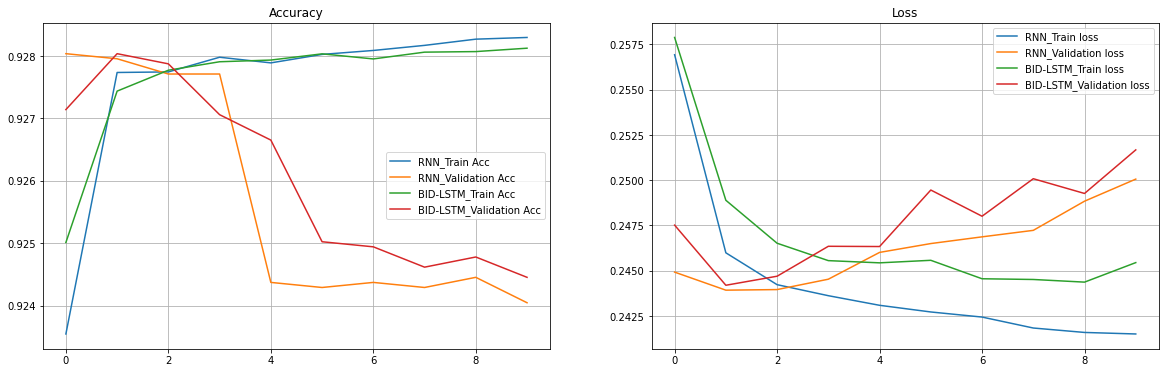

In [16]:
history = [history_BID,history_RNN]
plot_result_comparison_2_models(history)

Test models on new input.

In [17]:
x = pd.Series(['Our room was excellent! The view was superb, we had a fantastic time.'])
sentiment = ['Negative','Positive']

test = preprocess(x)
result_BID = sentiment[np.around(BID_model.predict(test), decimals=0).argmax(axis=1)[0]]
result_RNN = sentiment[np.around(RNN_model.predict(test), decimals=0).argmax(axis=1)[0]]

print(f'Test review: {x[0]}')
print(f'Sentiment analyzed by bidirectional LSTM: {result_BID}')
print(f'Sentiment analyzed by RNN: {result_RNN}')

Test review: Our room was excellent! The view was superb, we had a fantastic time.
Sentiment analyzed by bidirectional LSTM: Positive
Sentiment analyzed by RNN: Positive


It seems that under the above circumstances (same set of hyperparameters and inputs), both models are very accurate, but the RNN is slightly faster in running time.